## Morgage at risk of foreclosure in case of economic recession

### Kayode Ayankoya, PhD

#### Introduction
The 2008 recession was a eye-opener for the government of many countries, organizations, industries and individuals. One of the common occurrences during periods of recession is that some mortgage loans that were not at risk of default in a normal economy become suseptible to foreclosures due to significant changes in financial status of borrowers.

This study will use the single-family mortgage dataset made available by Fannie Mae to predict if a mortgage will or will not foreclose as a result of recession.

#### Data and Methodology
Fannie Mae, a government-sponsored enterprise that offers different type of mortagage loans provide open access to Single Family Morgage dataset that will be used for this study. The dataset is structured into 2 categories (Acquisition and Performance) on a quaterly basis. The acquisition dataset contain static data, while the performance dataset for each acquisition is updated monthly. 

For the purpose of this study, 109874 of mortgages acquired in Q2 and Q3 of 2006 were sampled and the performance dataset for the same loans were extracted, summarised and merged with the acquisition. All mortgages were initialize in the same year (2008) and performance data for these mortgages were available through to 2018. However, only loans whose last payment date fell between 01JAN2008 and 31DEC2018 were considered foreclosed for the purpose of this study. 

After removing records with missing data, the final dataset has 97,386 records which was splitted into 2 categories randomly, with 75% for training and 25% as the test set. Furthermore, 23841 sample where extracted from the Q4 of 2006 and used as the validation set.

In [45]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import data
df = pd.read_csv('FNMA_Performance_All.csv', 
                 index_col="LOAN_ID")
df.columns

Index(['ORIG_CHN', 'ORIG_RT', 'ORIG_AMT', 'ORIG_TRM', 'ORIG_DTE', 'FRST_DTE',
       'OLTV', 'OCLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'FTHB_FLG', 'PURPOSE',
       'PROP_TYP', 'NUM_UNIT', 'OCC_STAT', 'STATE', 'ZIP_3', 'MI_PCT',
       'CSCORE_C', 'MI_TYPE', 'RELOCATION_FLG', 'CSCORE_MN', 'ORIG_VAL',
       'LAST_RT', 'LAST_UPB', 'MSA', 'MOD_FLAG', 'Zero.Bal.Code', 'LPI_DTE',
       'FCC_DTE', 'DISP_DT', 'FCC_COST', 'PP_COST', 'AR_COST', 'IE_COST',
       'TAX_COST', 'NS_PROCS', 'CE_PROCS', 'RMW_PROCS', 'O_PROCS',
       'NON_INT_UPB', 'REPCH_FLAG', 'TRANSFER_FLG', 'PRIN_FORG_UPB',
       'MODTRM_CHNG', 'MODUPB_CHNG', 'Fin_UPB', 'modfg_cost', 'C_modir_cost',
       'C_modfb_cost', 'LAST_STAT', 'zb2disp', 'INT_COST', 'NET_LOSS',
       'NET_SEV', 'Total_Cost', 'Tot_Procs', 'Tot_Liq_Ex', 'LAST_DTE',
       'FMOD_DTE', 'FMOD_UPB', 'FCE_DTE', 'FCE_UPB', 'F180_DTE', 'F180_UPB',
       'VinYr', 'ActYr', 'DispYr', 'MODIR_COST', 'MODFB_COST', 'MODTOT_COST'],
      dtype='object')

In [3]:
#Build a list of the relevant columns - this list will help with easy updates
rel_col = ['ORIG_CHN','ORIG_RT', 'ORIG_AMT', 'ORIG_TRM', 'OLTV', 'OCLTV',
           'NUM_BO', 'DTI', 'CSCORE_B', 'FTHB_FLG', 'PURPOSE', 'PROP_TYP',
           'NUM_UNIT', 'OCC_STAT', 'STATE', 'ZIP_3', 'MI_PCT', 'CSCORE_C',
           'RELOCATION_FLG', 'CSCORE_MN', 'ORIG_VAL', 'LAST_RT', 'LAST_UPB',
           'MSA', 'MOD_FLAG', 'Zero.Bal.Code', 'LPI_DTE', 'LAST_STAT']           

In [4]:
df1 = df.loc[:,rel_col]

#df1["LPI_DT"] = datetime.strptime( df1.loc[:,"LPI_DTE"], '%m-%d-%Y') 
df1["LPI_DT"] = pd.to_datetime(df1["LPI_DTE"])

#Create new variable for Foreclosure for mortgages 
df1["FCC_FLG"] = df1.apply(lambda row: 1 if (row["LPI_DT"] <= datetime.strptime('12-31-2010', '%m-%d-%Y')) &
              (row["LPI_DT"] >= datetime.strptime('01-01-2008', '%m-%d-%Y')) else 0, axis=1)

df1["FCC_FLC"] = df1['FCC_FLG'].apply(lambda row: 'Foreclosed' if row == 1 else 'Not Foreclosed')

df_all_fore = df1[(df1["LPI_DT"] <= datetime.strptime('12-31-2019', '%m-%d-%Y')) &
              (df1["LPI_DT"] >= datetime.strptime('01-01-2006', '%m-%d-%Y'))]

df_fore_res = df1[(df1["LPI_DT"] <= datetime.strptime('12-31-2010', '%m-%d-%Y')) &
              (df1["LPI_DT"] >= datetime.strptime('01-01-2008', '%m-%d-%Y'))]

## Exploratory Data Analysis
The baseline for this study are loans initiated in 2006. But we are interested in loans that were foreclosed between 2008 and 2010 in order to identify properties foreclosed as a result of recession.

We will first like to see a graph showing property the number of foreclosures per month between 2006 and 2018.

### What is the distribution of Mortgage loan foreclosures over the years?

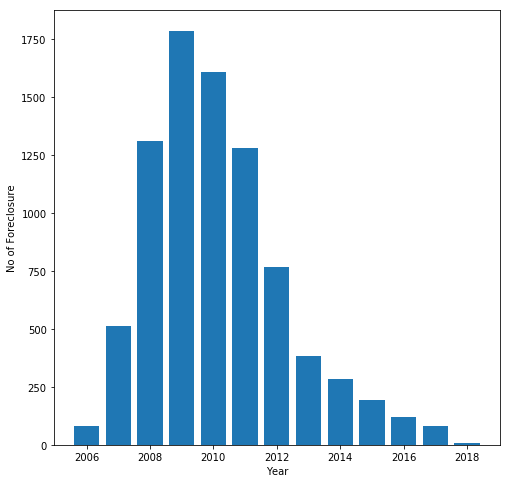

In [5]:
df_fore = df_all_fore['LPI_DT'].groupby([df_all_fore.LPI_DT.dt.year]).agg('count')
df_fore = pd.DataFrame(df_fore)

df_fore.columns = ['Foreclosures']

dd = df_fore.reset_index(level=0)
dd.columns = ['year','Foreclosures']

plt.figure(1, figsize=(8, 8))
plt.bar(dd['year'], dd['Foreclosures'], data=dd)
plt.xlabel('Year')
plt.ylabel('No of Foreclosure')
plt.show()

The plot above shows clearly that there was a spike in the number of foreclosures between 2008 and 2012. It can be noticed that the number of foreclosures was at the highest level between 2009 and 2010, but it reduced significantly from 2013, which could be as a result of full economic recovery. This suggests that the most risky period for loan foreclosures is from the first month of economic recession and 24 months thereafter. Hence this stusy will be looking at the profile of customers that are most likely to foreclose.

### What is the relationship between the the interest rate, loan to value, cummulative loan to value and foreclosures

We will explore the interest rate and loan to value (LTV) for all the loans in the sample below. LTV is the percentage of the loan to the value of asset. But we will also look at the cumulative loan to value (CLTV)

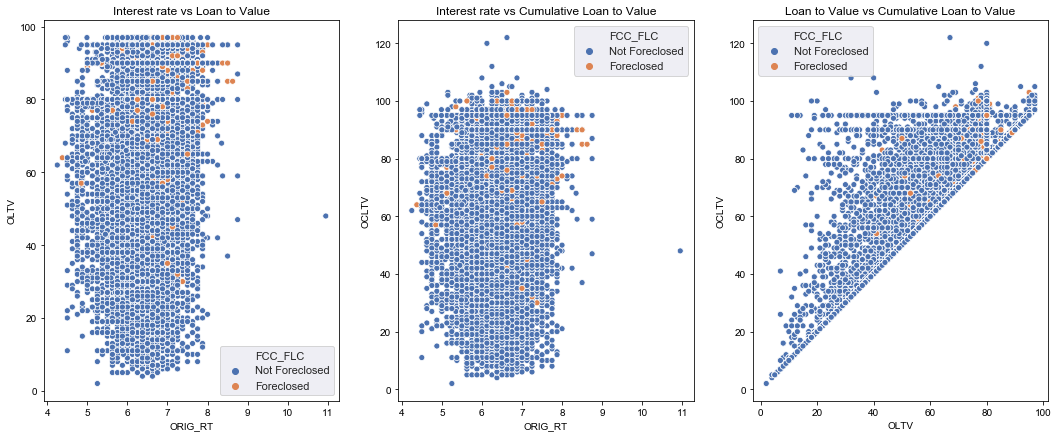

In [6]:
plt.rcParams["figure.figsize"] = (18,7)
fig, axs = plt.subplots(ncols=3)
sns.set(font_scale=1)


sns.scatterplot(x=df1.loc[:,'ORIG_RT'], y=df1.loc[:,'OLTV'], hue=df1['FCC_FLC'], ax = axs[0]).set_title('Interest rate vs Loan to Value')
sns.scatterplot(x=df1.loc[:,'ORIG_RT'], y=df1.loc[:,'OCLTV'], hue=df1['FCC_FLC'], ax = axs[1]).set_title('Interest rate vs Cumulative Loan to Value')
sns.scatterplot(x=df1.loc[:,'OLTV'], y=df1.loc[:,'OCLTV'], hue=df1['FCC_FLC'], ax = axs[2]).set_title('Loan to Value vs Cumulative Loan to Value')
plt.show()

The plot above compares the interest rate and loan to value of all the loans in the dataset. it appears that most of the foreclosed loans seem to be associated with higher interst rates and higher loan to value. However, the plot did not do enough justice to this fact because of the ratio of the foreclosed loans to those not foreclosed.

Hence the segment below will look at all loans that a foreclosed during the recession and 24 months there after the first recession month.

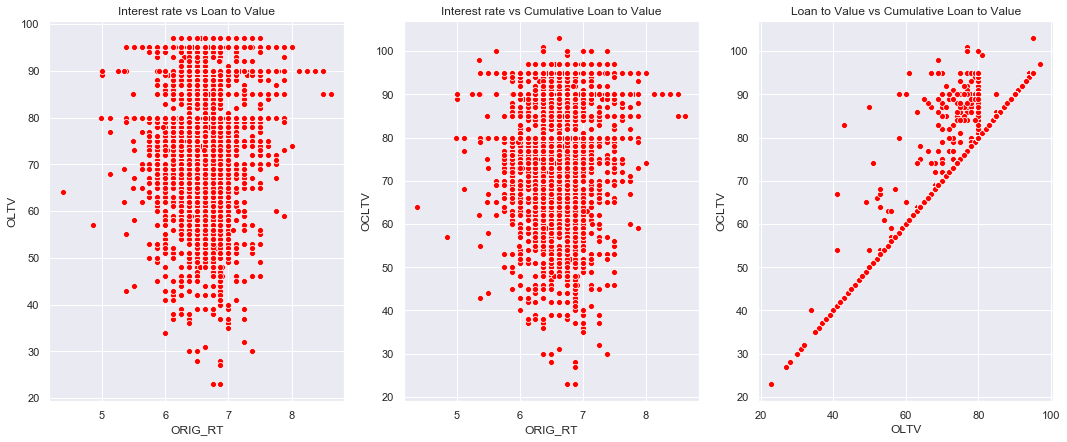

In [7]:

plt.rcParams["figure.figsize"] = (18,7)
fig, axs = plt.subplots(ncols=3)
sns.set(font_scale=1)


sns.scatterplot(x=df_fore_res.loc[:,'ORIG_RT'], y=df_fore_res.loc[:,'OLTV'], color='red', ax = axs[0]).set_title('Interest rate vs Loan to Value')
sns.scatterplot(x=df_fore_res.loc[:,'ORIG_RT'], y=df_fore_res.loc[:,'OCLTV'], color='red', ax = axs[1]).set_title('Interest rate vs Cumulative Loan to Value')
sns.scatterplot(x=df_fore_res.loc[:,'OLTV'], y=df_fore_res.loc[:,'OCLTV'], color='red', ax = axs[2]).set_title('Loan to Value vs Cumulative Loan to Value')
plt.show()

The first and the second plots show that many of the foreclosed loans have high interest rates between 6 and almost 9% in some cases. Also 3rd plor show  that some of the loans have high cummulative loan to value. Although tghis is expected in most cases.

### Is there a pattern in credit score of loans that default during recession?

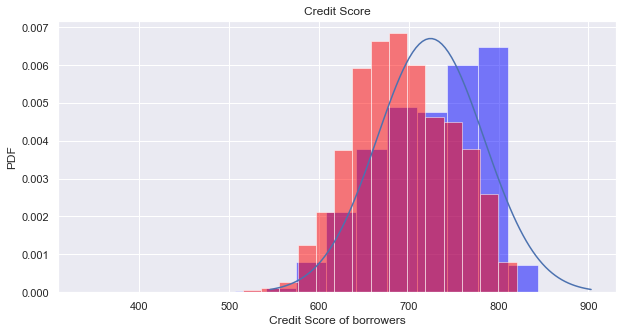

In [8]:
#Calculate mean and standard deviation of temperature
s_mean = df1['CSCORE_B'].mean()
s_std = df1['CSCORE_B'].std()


plt.rcParams["figure.figsize"] = (10,5)
_ = plt.hist(df1['CSCORE_B'], bins=15, density=True, alpha=0.5, color='blue')
_ = plt.hist(df_fore_res['CSCORE_B'], bins=15, density=True, alpha=0.5, color='red')


x = np.linspace(s_mean - 3*s_std, s_mean + 3*s_std, 100)
y = stats.norm.pdf(x, s_mean, s_std)
plt.plot(x,y)

_ = plt.xlabel('Credit Score of borrowers')
_ = plt.ylabel('PDF')
_ = plt.title('Credit Score')
plt.show()

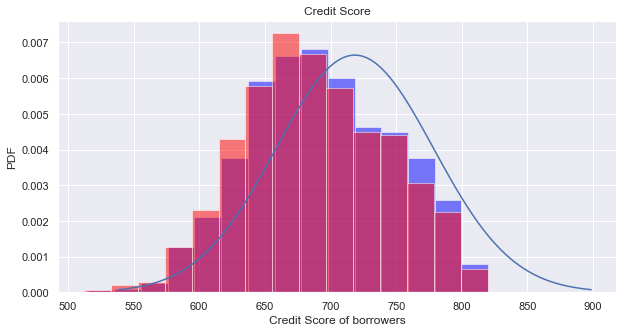

In [9]:
#Calculate mean and standard deviation of temperature
s_mean = df1['CSCORE_MN'].mean()
s_std = df1['CSCORE_MN'].std()


plt.rcParams["figure.figsize"] = (10,5)
_ = plt.hist(df_fore_res['CSCORE_B'], bins=15, density=True, alpha=0.5, color='blue')
_ = plt.hist(df_fore_res['CSCORE_MN'], bins=15, density=True, alpha=0.5, color='red')


x = np.linspace(s_mean - 3*s_std, s_mean + 3*s_std, 100)
y = stats.norm.pdf(x, s_mean, s_std)
plt.plot(x,y)

_ = plt.xlabel('Credit Score of borrowers')
_ = plt.ylabel('PDF')
_ = plt.title('Credit Score')
plt.show()

The distribution credit score of loans foreclosed during recession peaks at about 680 with a majority range between 650 -720. However, the general distribution seem to be clustered around 760 - 820.

### Feature Engineering
Some of the variables extracted will cannot be used in its original form

From experiments carried out, dropping all the missing value seem to be more beneficial than trying to fill because it actually improved the percentage of Foreclosed loans of interest to those not foreclosed.

In [10]:
df2 = df1.drop(columns =['CSCORE_C', 'LPI_DTE', 'LPI_DT','MSA', 'ZIP_3','MI_PCT'])
df_all = df2.dropna()
df_label = df_all.loc[:, ["FCC_FLG",'FCC_FLC']]

lbe = LabelEncoder()

df_features = df_all.drop(columns =["FCC_FLG",'FCC_FLC'])
df_features['ORIG_CHN'] = lbe.fit_transform(df_all['ORIG_CHN'])
df_features['FTHB_FLG'] = lbe.fit_transform(df_all['FTHB_FLG'])
df_features['PURPOSE'] = lbe.fit_transform(df_all['PURPOSE'])
df_features['PROP_TYP'] = lbe.fit_transform(df_all['PROP_TYP'])
df_features['OCC_STAT'] = lbe.fit_transform(df_all['OCC_STAT'])
df_features['STATE'] = lbe.fit_transform(df_all['STATE'])
df_features['RELOCATION_FLG'] = lbe.fit_transform(df_all['RELOCATION_FLG'])
df_features['MOD_FLAG'] = lbe.fit_transform(df_all['MOD_FLAG'])
df_features['LAST_STAT'] = lbe.fit_transform(df_all['LAST_STAT'])

df_label['FCC_FLC'].value_counts() 

Not Foreclosed    92832
Foreclosed         4536
Name: FCC_FLC, dtype: int64

There is a concerned that recoding the data may affect the result because of the many important categorical features. Hence dummy variables will be created for each of the categorical variables

In [11]:
df_feat = df_all.drop(columns =["FCC_FLG",'FCC_FLC'])
df_feature_d = pd.get_dummies(df_feat, columns=['ORIG_CHN', 'FTHB_FLG','PURPOSE','PROP_TYP',
                                           'OCC_STAT','STATE','RELOCATION_FLG','MOD_FLAG',
                                           'LAST_STAT'], drop_first=True)
df_feature_d.shape

(97368, 87)

### Split Data into Training and Test Set and confirm proportions

In [12]:
# Split the data into a training and test set.
xtrain, xtest, ytrain, ytest = train_test_split(df_feature_d.values, 
                                              df_label['FCC_FLG'].values ,random_state=5)

print(ytrain.shape)
print(ytest.shape)

(73026,)
(24342,)


In [13]:
#unique, counts = np.unique(ytrain[0], return_counts=True)
#dict(zip(unique, counts))
y = list(ytrain)
j = list(ytest)
print('There are {0} None ForeClosures and {1} Foreclosures in the training set'.format(y.count(0), y.count(1)))
print('There are {0} None ForeClosures and {1} Foreclosures in the training set'.format(j.count(0), j.count(1)))

There are 69631 None ForeClosures and 3395 Foreclosures in the training set
There are 23201 None ForeClosures and 1141 Foreclosures in the training set


This is a well proportioned split

### Baseline Model

In [14]:
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(xtrain, ytrain)
# Print the accuracy from the testing data.
print(accuracy_score(ytest, clf.predict(xtest)))

0.9525100649083887


### Cross Validation with Baseline Model

In [15]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 10
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [16]:
clf = LogisticRegression()
score = cv_score(clf, xtrain, ytrain)
print(score)

0.9519486613280084


In [17]:
#w = clf.coef_
#w

In [18]:
#print(np.std(xtrain, 0)*clf.coef_)
#print(clf.intercept_)

The baseline model is showing some promise because the average score from a 10 fold cross validation is still close the baseline model. But we are not going to just accept that. Hence the next segment will attempt to fine tune the model by implementing the GridSearch in a bid to look for the optimal hyperparameter (c) for the logistic regression model.

### Grid Search - Fine Tuning

In [19]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'penalty': ['l1','l2'],'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(xtrain, ytrain)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.05179474679231213, 'penalty': 'l1'}
Best score is 0.9768849450880508


### Now we can check the performance of the model proposed by GridSearchCV on the hold-out set

In [20]:
#Check performance of model
print(accuracy_score(logreg_cv.predict(xtest), ytest))

0.9762961137129241


In [21]:
tn, fp, fn, tp = confusion_matrix(logreg_cv.predict(xtest), ytest).ravel()
(tn, fp, fn, tp)

(22728, 104, 473, 1037)

### Model Validation
The baseline model had a 0.95 score which seem to be very high and raises a concern of overfitting. However, the score was improved after implementing Grid Search and Cross Validation for fine tuning. Although the training model has not seen the testing data at all, the 0.97 score almost sound too good to be true. Hence it was decided to carry out a validation since there is a luxury of more data.

The initial dataset that was split into training and test sets was sampled from 109873 loans intiated in the second and third quarters on 2006. Therefore, for the purpose of validation, a sample of 28,321 loans have been extracted from loan initiated in the fourth quarter of 2006.

### Obtain and prepare validation Data

In [22]:
#Import data
df_v = pd.read_csv('FNMA_Performance_Data_Q4.csv', 
                 index_col="LOAN_ID")

df1_v = df_v.loc[:,rel_col]

#df1["LPI_DT"] = datetime.strptime( df1.loc[:,"LPI_DTE"], '%m-%d-%Y') 
df1_v["LPI_DT"] = pd.to_datetime(df1_v["LPI_DTE"])

#Create new variable for Foreclosure for mortgages 
df1_v["FCC_FLG"] = df1_v.apply(lambda row: 1 if (row["LPI_DT"] <= datetime.strptime('12-31-2010', '%m-%d-%Y')) &
              (row["LPI_DT"] >= datetime.strptime('01-01-2008', '%m-%d-%Y')) else 0, axis=1)

df1_v["FCC_FLC"] = df1_v['FCC_FLG'].apply(lambda row: 'Foreclosed' if row == 1 else 'Not Foreclosed')

df_all_fore_v = df1_v[(df1_v["LPI_DT"] <= datetime.strptime('12-31-2019', '%m-%d-%Y')) &
              (df1_v["LPI_DT"] >= datetime.strptime('01-01-2006', '%m-%d-%Y'))]

df_fore_res_v = df1_v[(df1_v["LPI_DT"] <= datetime.strptime('12-31-2010', '%m-%d-%Y')) &
              (df1_v["LPI_DT"] >= datetime.strptime('01-01-2008', '%m-%d-%Y'))]

In [23]:
df2_v = df1_v.drop(columns =['CSCORE_C', 'LPI_DTE', 'LPI_DT','MSA', 'ZIP_3','MI_PCT'])
df_all_v = df2_v.dropna()
df_label_v = df_all_v.loc[:, ["FCC_FLG",'FCC_FLC']]

lbe_v = LabelEncoder()

df_features_v = df_all_v.drop(columns =["FCC_FLG",'FCC_FLC'])
df_features_v['ORIG_CHN'] = lbe_v.fit_transform(df_all_v['ORIG_CHN'])
df_features_v['FTHB_FLG'] = lbe_v.fit_transform(df_all_v['FTHB_FLG'])
df_features_v['PURPOSE'] = lbe_v.fit_transform(df_all_v['PURPOSE'])
df_features_v['PROP_TYP'] = lbe_v.fit_transform(df_all_v['PROP_TYP'])
df_features_v['OCC_STAT'] = lbe_v.fit_transform(df_all_v['OCC_STAT'])
df_features_v['STATE'] = lbe_v.fit_transform(df_all_v['STATE'])
df_features_v['RELOCATION_FLG'] = lbe_v.fit_transform(df_all_v['RELOCATION_FLG'])
df_features_v['MOD_FLAG'] = lbe_v.fit_transform(df_all_v['MOD_FLAG'])
df_features_v['LAST_STAT'] = lbe_v.fit_transform(df_all_v['LAST_STAT'])

df_label_v['FCC_FLC'].value_counts() 

Not Foreclosed    23601
Foreclosed         1230
Name: FCC_FLC, dtype: int64

In [27]:
df_feat_v = df_all_v.drop(columns =["FCC_FLG",'FCC_FLC'])
df_feature_d_v = pd.get_dummies(df_feat_v, columns=['ORIG_CHN', 'FTHB_FLG','PURPOSE','PROP_TYP',
                                           'OCC_STAT','STATE','RELOCATION_FLG','MOD_FLAG',
                                           'LAST_STAT'], drop_first=True)
df_feature_d_v.shape

(24831, 87)

In [31]:
# Split the data into a training and test set.
xtrain_v, xtest_v, ytrain_v, ytest_v = train_test_split(df_feature_d_v.values, 
                                              df_label_v['FCC_FLG'].values ,random_state=5, test_size=0.9999)

print(ytrain_v.shape)
print(ytest_v.shape)

(2,)
(24829,)


In [41]:
#Check performance of model
y_pred_v = logreg_cv.predict(xtest_v)
print(accuracy_score(y_pred_v, ytest_v))

0.9759152603810061


In [42]:
tn, fp, fn, tp = confusion_matrix(y_pred_v, ytest_v).ravel()
(tn, fp, fn, tp)

(23097, 96, 502, 1134)

### Test Recall/Validtion

In [55]:
print(classification_report(ytest, logreg_cv.predict(xtest)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     23201
           1       0.69      0.91      0.78      1141

   micro avg       0.98      0.98      0.98     24342
   macro avg       0.84      0.94      0.88     24342
weighted avg       0.98      0.98      0.98     24342



### Validation Recall/Precision

In [44]:
print(classification_report(ytest_v, y_pred_v))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     23599
           1       0.69      0.92      0.79      1230

   micro avg       0.98      0.98      0.98     24829
   macro avg       0.84      0.95      0.89     24829
weighted avg       0.98      0.98      0.98     24829



### ROC Curve

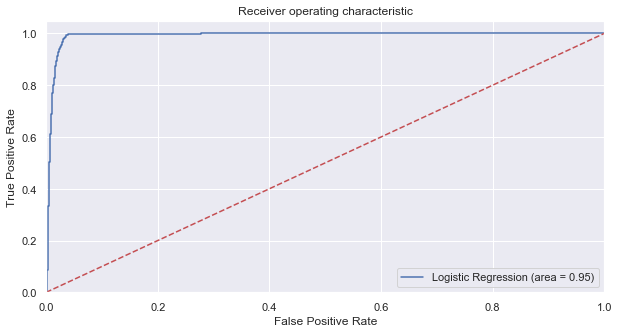

In [46]:

logit_roc_auc = roc_auc_score(ytest_v, logreg_cv.predict(xtest_v))
fpr, tpr, thresholds = roc_curve(ytest_v, logreg_cv.predict_proba(xtest_v)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Importance of Features

In [60]:
# The estimated coefficients will all be around 1:
#print(clf.coef_)

# Those values, however, will show that the second parameter
# is more influential
print(np.std(xtest, 0)*clf.coef_)

[[ 9.33701562e-05 -2.59427757e+00  3.52477123e-01  3.36127000e-02
   2.97087686e-02 -1.18005554e-04  6.38962687e-02 -2.67035840e-01
   9.26740654e-06 -1.71259405e-01 -1.28047881e+00  1.43609957e-04
   3.70954989e+00  2.45490661e-02  8.62837738e-06 -4.26554921e-05
  -5.73033029e-08 -2.31970619e-05 -1.19931892e-04  1.15153828e-05
  -4.26367807e-07  8.57992003e-07  2.65447949e-05 -4.52540106e-05
  -2.89827523e-05  7.40317850e-06 -1.70739433e-06 -9.19642287e-07
   2.56765740e-05  3.93348972e-05 -3.49013691e-06 -1.30760033e-06
  -1.55864089e-07 -4.81632058e-07  8.35662514e-05  9.95725414e-07
  -1.19172319e-09 -1.76257367e-07 -1.22390224e-06  4.72263452e-07
  -5.70378477e-06 -5.52947444e-07 -1.01443012e-06 -1.15150230e-06
  -2.64783282e-06 -2.92371779e-06 -2.23432576e-06 -3.46388825e-07
   7.09743588e-06  1.79925594e-07 -3.77796763e-06 -1.38172691e-06
  -4.20555742e-07 -6.33527650e-06 -8.47081662e-08 -2.98927639e-07
  -5.79318723e-07 -3.43110260e-06 -8.39942773e-07  4.68772776e-06
  -7.26975